In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.stats import spearmanr
from sklearn.preprocessing import minmax_scale
from pathlib import Path
from matplotlib.gridspec import GridSpec

In [2]:
sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.dataprep import default_prep, filter_predictor_set, j_measure, perkins

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import collapse_restore_multiindex

2022-03-21 11:11:22.143687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 11:11:22.143707: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def load_sequential(name: str, basepath: Path):
    temp = pd.read_csv(basepath / f'{name}.csv', index_col = 0, header = 0)
    collapse_restore_multiindex(temp, axis = 1, names = ['variable','timeagg','clustid','metric'], dtypes = [str,int,int,str], inplace = True)
    return temp

def percentual_improvement(name: str, basepath: Path = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/')):
    """Multipass change in the scores"""
    assert '_multi_' in name, f'Can only be computed on a multipass file. Check {name}'
    temp = load_sequential(name = name, basepath = basepath).loc['rps']
    old = temp.iloc[:-1]
    old.index = temp.index[1:] # The score upon which the predictor (index) should improve
    new = temp.iloc[1:]
    return((new-old)/old * 100)

def compute_imps(targetname, with_gmst = True):
    """ 
    Returns j_measures and 1-p_measures computed on the trainval set 
    """
    prepared_data, _ = default_prep(predictandname = targetname, npreds = None) # Loads all predictors from pre-saved files
    obs_trainval = prepared_data.crossval.obs_trainval
    X_trainval = prepared_data.crossval.X_trainval
    # Test what a trend variable does. Not a trend in probability
    # So perhaps just global mean surface temperature?
    if with_gmst:
        trend_path = '/nobackup/users/straaten/predsets/tg_monthly_global_mean_surface_only_trend.nc'
        trend = xr.open_dataarray(trend_path).to_dataframe()
        trend.columns = pd.MultiIndex.from_tuples([('tg-anom',31,0,'mean')], names = X_trainval.columns.names)
        X_trainval = X_trainval.join(trend, how = 'left')
    _, js = filter_predictor_set(X_trainval, obs_trainval.iloc[:,-1].astype(bool), how = j_measure, return_measures = True, nmost_important = 1, nbins=10)
    _, ps = filter_predictor_set(X_trainval, obs_trainval.iloc[:,-1].astype(bool), how = perkins, return_measures = True, nmost_important = 1, nbins = 10)
    oneminps = 1 - ps
    oneminps.name = f'1-{ps.name}'
    return pd.concat([js, oneminps], axis = 1)

def load_sequential_imps(name: str, npreds: int = None, force_rank = True):
    """
    Loads the sequential forward importances. (Ranks)
    can be single (lots of predictors) or multi (only n_depth of predictors)
    you can supply the total number of predictors (not inferable from size of the multi file)
    """
    temp = load_sequential(name = name, basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/'))
    if (npreds is None):
        npreds = len(temp.columns)
    if ('multi' in name) or force_rank:
        result = npreds - temp.loc['rank']
    else: # Singlepass, and not force_rank
        result = -temp.loc['rps']
    return result

def load_combine_all(targetname: str, with_gmst = False) -> pd.DataFrame:
    """
    Default way of loading and joining all importance measures: jmeasure, perkins,
    single and multi (with nan's for multi)
    """
    measures = compute_imps(targetname =targetname, with_gmst = with_gmst)
    single = load_sequential_imps(name = targetname + '_single_d20_b3',force_rank=False)
    single.name = 'single'
    multi = load_sequential_imps(name = targetname + '_multi_d20_b3', npreds = len(single))
    multi.name = 'multi'
    combined = measures.join(single, how = 'left').join(multi, how = 'left')
    return combined
    
def scatter(df, xcol, ycol, n_names = 10, title: str = None):
    """
    Plots two columns of the dataframe (potentially sorted) against each other
    names the bottom n_names rows by their index value
    """
    fig, ax = plt.subplots()
    ax.scatter(x = df[xcol], y = df[ycol], alpha = 0.3)
    try: 
        trendpoint = df.loc[('tg-anom',31,0,'mean'),:]
        ax.scatter(x = trendpoint.loc[xcol], y = trendpoint.loc[ycol], color = 'red')
    except KeyError:
        pass
    for i in range(n_names):
        #ax.text(x = df[xcol].iloc[-i], y = df[ycol].iloc[-i], s = str(df.index[-i]))
        ax.annotate(str(df.index[i]), xy = (df[xcol].iloc[i],df[ycol].iloc[i]), xycoords = 'data',
                    xytext=(1.05,np.linspace(1,0,num=n_names)[i]), textcoords='axes fraction',
                   arrowprops=dict(color='grey', shrink=0.01, width = 0.2, headwidth = 0.8, zorder = 0))
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    if not (title is None):
        ax.set_title(title)
    return fig, ax

### Visulization single predictand
Joint visualization of character and several importances for the most successful model.

In [4]:
timeagg = 31
quantile = 0.5
targetname = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15' 
combined = load_combine_all(targetname)
#combined.loc[combined['multi'].isnull(),'multi'] = 1

reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler


/nobackup_1/users/straaten/DLVENV/lib64/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/nobackup_1/users/straaten/DLVENV/lib64/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])
/nobackup_1/users/straaten/DLVENV/lib64/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names 

using a pre-fitted feature scaler


In [5]:
spherebook = {'oceanic':['sst','sst_nhplus','siconc_nhmin','pdo'],
           'terrestrial':['swvl13_europe','swvl4_europe','transp_europe','swvl4', 'swvl13','snowc_nhmin'],
           'atmospheric':['z','z-reg','mjo','z300_nhnorm','t850_nhblock','tcc_europe']}
sourcebook = {'forc':['swvl13','swvl4','z','z-reg','sst'],
              'init':['sst_nhplus','siconc_nhmin','pdo','swvl13_europe','swvl4_europe','transp_europe',
                               'snowc_nhmin','mjo','z300_nhnorm','t850_nhblock','tcc_europe']}

In [6]:
properties = combined.reset_index('timeagg')[['timeagg']]
properties['sphere'] = properties.index.get_level_values('variable').to_series().apply(lambda s: [key for key in spherebook.keys() if s in spherebook[key]][0]).values
properties['source'] = properties.index.get_level_values('variable').to_series().apply(lambda s: [key for key in sourcebook.keys() if s in sourcebook[key]][0]).values
# Order of the final plot?
properties = properties.sort_values(['sphere','timeagg','source']).set_index('timeagg', drop = False, append = True)
properties.index = properties.index.reorder_levels(combined.index.names)

In [7]:
scaled = pd.DataFrame(minmax_scale(combined), columns = combined.columns, index = combined.index)

In [8]:
def plot_consecutive_categories(ax, data: pd.Series, cmap = 'RdYlGn'):
    unique = list(np.unique(data))
    category_colors = plt.get_cmap(cmap)(np.linspace(0.15,0.85,len(unique)))
    breaks = data != data.shift()
    consecutive_groups = breaks.cumsum()
    consecutive_lengths = consecutive_groups.groupby(consecutive_groups).count()
    consecutive_lengths.index = data.loc[breaks]
    
    start = 0
    for label, n_consecutive in zip(consecutive_lengths.index, consecutive_lengths):
        color = category_colors[unique.index(label)]
        rects = ax.barh(y = 0.5, width = n_consecutive, left=start, height=1,
                        label=label, color=color)
        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, labels = [label], label_type='center', color=text_color)
        start += n_consecutive
    return ax

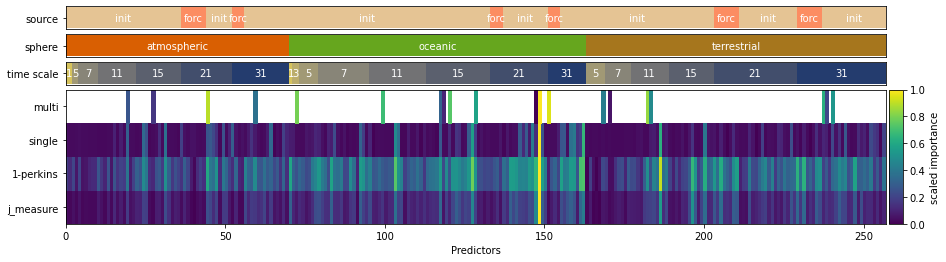

In [23]:
fig = plt.figure(figsize=(15,4), facecolor = 'white')
gs1 = GridSpec(nrows = 8, ncols = 50, hspace=0.2)
ax_imp = fig.add_subplot(gs1[3:, :-1])
ax_time = fig.add_subplot(gs1[2, :-1])
ax_source = fig.add_subplot(gs1[0, :-1])
ax_sphere = fig.add_subplot(gs1[1, :-1])

ax_cbar_imp = fig.add_subplot(gs1[3:, -1:])
ax_cbar_time = fig.add_subplot(gs1[:3, -1:])

im = ax_imp.pcolor(scaled.loc[properties.index,:].T)
ax_imp.set_yticks(np.arange(0.5, len(combined.columns)+0.5, 1))
ax_imp.set_yticklabels(combined.columns.values)
ax_imp.set_xlabel('Predictors')

plot_consecutive_categories(ax = ax_sphere, data = properties['sphere'], cmap = 'Dark2') #'RdYlGn'
ax_sphere.set_yticks([0.5])
ax_sphere.set_yticklabels(['sphere'])
ax_sphere.set_xlim(ax_imp.get_xlim())
ax_sphere.get_xaxis().set_visible(False)

plot_consecutive_categories(ax = ax_time, data = properties['timeagg'], cmap = 'cividis_r')
ax_time.set_yticks([0.5])
ax_time.set_yticklabels(['time scale'])
ax_time.set_xlim(ax_imp.get_xlim())
ax_time.get_xaxis().set_visible(False)

plot_consecutive_categories(ax = ax_source, data = properties['source'], cmap = 'Set2')
ax_source.set_yticks([0.5])
ax_source.set_yticklabels(['source'])
ax_source.set_xlim(ax_imp.get_xlim())
ax_source.get_xaxis().set_visible(False)

ax_cbar_time.set_visible(False)
fig.colorbar(im, cax = ax_cbar_imp, label = 'scaled importance')

#plt.savefig(os.path.expanduser('~/Pictures/predselec.png'), dpi = 160)
plt.show()

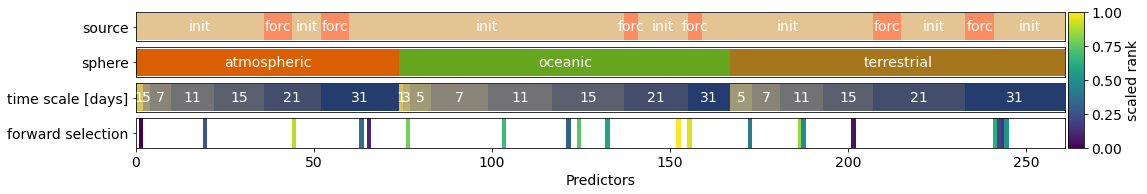

In [10]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(17,2.5), facecolor = 'white')
gs1 = GridSpec(nrows = 4, ncols = 50, hspace=0.2)
ax_imp = fig.add_subplot(gs1[3:, :-1])
ax_time = fig.add_subplot(gs1[2, :-1])
ax_source = fig.add_subplot(gs1[0, :-1])
ax_sphere = fig.add_subplot(gs1[1, :-1])

ax_cbar_imp = fig.add_subplot(gs1[:, -1:])

im = ax_imp.pcolor(scaled.loc[properties.index,['multi']].T)
ax_imp.set_yticks([0.5])
ax_imp.set_yticklabels(['forward selection'])
ax_imp.set_xlabel('Predictors')

plot_consecutive_categories(ax = ax_sphere, data = properties['sphere'], cmap = 'Dark2') #'RdYlGn'
ax_sphere.set_yticks([0.5])
ax_sphere.set_yticklabels(['sphere'])
ax_sphere.set_xlim(ax_imp.get_xlim())
ax_sphere.get_xaxis().set_visible(False)

plot_consecutive_categories(ax = ax_time, data = properties['timeagg'], cmap = 'cividis_r')
ax_time.set_yticks([0.5])
ax_time.set_yticklabels(['time scale [days]'])
ax_time.set_xlim(ax_imp.get_xlim())
ax_time.get_xaxis().set_visible(False)

plot_consecutive_categories(ax = ax_source, data = properties['source'], cmap = 'Set2')
ax_source.set_yticks([0.5])
ax_source.set_yticklabels(['source'])
ax_source.set_xlim(ax_imp.get_xlim())
ax_source.get_xaxis().set_visible(False)

fig.colorbar(im, cax = ax_cbar_imp, label = 'scaled rank')
plt.savefig(os.path.expanduser('~/Pictures/predselec.png'), dpi = 160,pad_inches = 0.2)
plt.show()

### Choices for multiple predictands

In [88]:
# First tganoms
basepath = Path('/nobackup/users/straaten/climpredsets/objective_balanced_cv/')
timeaggs = [21,31]
quantiles = [0.5, 0.66, 0.75, 0.9]
tg_index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','threshold'])
total = []
for timeagg, quantile in tg_index:
    targetname = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15' 
    combined = load_combine_all(targetname, with_gmst=True)
    combined.columns.name = 'measure'
    total.append(combined)

# Then tgex
timeaggs = [21]
thresholds = [5,7,9,11]
tex_index = pd.MultiIndex.from_product([timeaggs, thresholds], names = ['timeagg','threshold'])
for timeagg, threshold in tex_index:
    targetname = f'tg-ex-q0.75-21D_ge{threshold}D_sep12-15'
    combined = load_combine_all(targetname, with_gmst=True)
    combined.columns.name = 'measure'
    total.append(combined)
total = pd.concat(total, axis = 1, keys = tg_index.append(tex_index))

reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])
/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])
/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself
/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:416: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_test = time_scaler.transform(obs_test.index.get_level_values('time').to_julian_date()[:,np.newaxis])


reading full set, no objective selection
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


/usr/people/straaten/Documents/Weave/Weave/utils.py:154: FutureWarning: inplace is deprecated and will be removed in a future version.
  index.set_levels(index.levels[i].astype(dtype), level = i, inplace = True) # inplace here only affects the just created restoration index, not the df itself


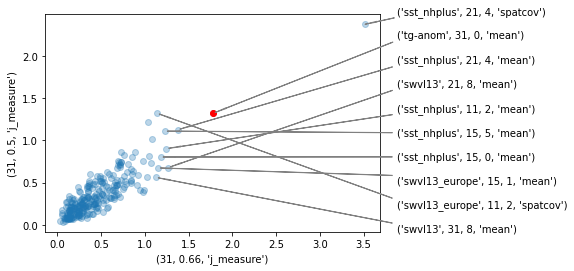

In [75]:
scatter(total.sort_values((31,0.66,'j_measure'), ascending = False), xcol = (31,0.66,'j_measure'), ycol = (31,0.5,'j_measure'))
plt.show()

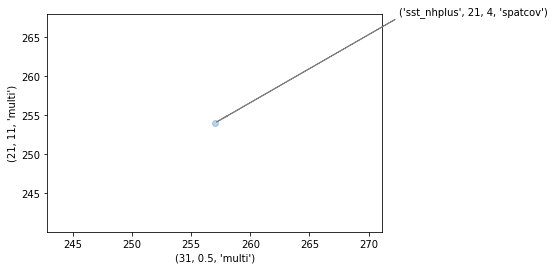

In [109]:
scatter(total.sort_values((31,0.5,'multi'), ascending = False), xcol = (31,0.5,'multi'), ycol = (21,,'multi'))
plt.show()

In [91]:
def cormatrix(no_missing: pd.DataFrame, title = ''):
    fig, ax = plt.subplots()
    im = ax.imshow(spearmanr(no_missing.values, axis = 0)[0], vmin = 0, vmax = 1)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(no_missing.columns)))
    ax.set_xticklabels(no_missing.columns.to_flat_index().values)
    ax.set_yticks(np.arange(len(no_missing.columns)))
    ax.set_yticklabels(no_missing.columns.to_flat_index().values)
    ax.set_title(title)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    return fig, ax

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

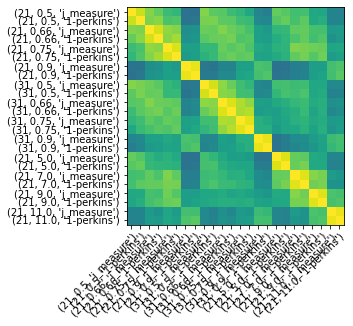

In [93]:
cormatrix(total.drop(['single','multi'], axis = 1, level = -1))

* High correspondence between perkins and jmeasure within a certain predictand
* Tganom >q0.9 (especially 21 day) is more different from the others. More so than tgex > 11D
* Inside tgex (5-9days) there is less correspondence than inside tganom (q0.5 - q0.75)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

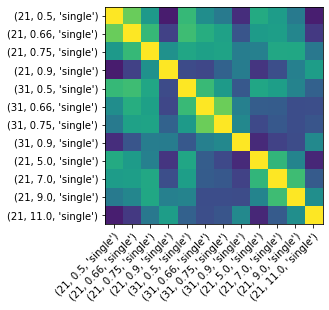

In [94]:
cormatrix(total.loc[:,(slice(None),slice(None),'single')].dropna(axis = 0, how = 'all'))

## Percentual improvement Leadtime 12-15
New series with continuous projection instead of duplication. Also local 21day and 31day dynamic variables

When requiring a 3 percent improvement in the score these would be the subsets coming from multipass.
Note that sst.21.4.spatcov is not visible for tgex5 and tganom21, because it is the first predictor.

In [77]:
#basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/regimeshortscale/')
#basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/')
#basepath = Path('/nobackup/users/straaten/climpredsets/objective_balanced_cv/regimeshortscale/')
basepath = Path('/nobackup/users/straaten/climpredsets/objective_balanced_cv/')
timeaggs = [21,31]
quantiles = [0.5, 0.66, 0.75, 0.9]
index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','quantile'])
percentages = pd.Index(np.arange(3,8,1), name = 'min_improvement[%]')
tganom_npreds = pd.DataFrame(0, index = index, columns = percentages)
for timeagg, quantile in index:
    imp = percentual_improvement(name = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15_multi_d20_b3', basepath=basepath)
    greater = -imp.values[:,np.newaxis] >= percentages.values[np.newaxis,:]
    shift = np.argmin(greater, axis = 0) # First occurrences of a False
    tganom_npreds.loc[(timeagg,quantile),:] = shift + 1 # First predictor always taken into account (not in the percentual improvement list)
    
ndaythresh = np.arange(5,13,2, dtype = int)
index = pd.Index(ndaythresh, name = 'ndaythresh')
tgex_npreds = pd.DataFrame(0, index = index, columns = percentages)
for nday in index:
    imp = percentual_improvement(name = f'tg-ex-q0.75-21D_ge{nday}D_sep12-15_multi_d20_b3', basepath = basepath)
    greater = -imp.values[:,np.newaxis] >= percentages.values[np.newaxis,:]
    shift = np.argmin(greater, axis = 0) # First occurrences of a False
    tgex_npreds.loc[nday,:] = shift + 1 

In [75]:
tganom_npreds

min_improvement[%]   3   4  5  6  7
timeagg quantile                   
21      0.50         4   4  3  3  3
        0.66         5   3  3  2  2
        0.75         7   3  3  3  3
        0.90        16  15  4  4  4
31      0.50         5   3  3  3  2
        0.66         5   5  3  3  2
        0.75         7   5  4  4  2
        0.90         3   3  3  2  2

In [78]:
tganom_npreds

min_improvement[%]   3  4  5  6  7
timeagg quantile                  
21      0.50         4  3  3  3  2
        0.66         4  4  3  2  2
        0.75         4  4  4  4  4
        0.90         6  6  4  4  4
31      0.50         8  4  3  2  2
        0.66         7  6  3  3  2
        0.75         6  6  4  3  3
        0.90        13  5  2  2  2

### Change of best performing results with different crossval split
31 day > q0.5 different test and trainval split.
nordic soilm stays in the best set. sst and t850 disappear. Local dynamical soilmoisture enters the picture as 3rd predictor.

In [64]:
basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/regimeshortscale/')
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.9_sep12-15_multi_d20_b3'
imp = percentual_improvement(name = name, basepath=basepath)
load_sequential(name = name, basepath = basepath).columns

MultiIndex([(   'sst_nhplus', 21, 4, 'spatcov'),
            ('transp_europe', 31, 1, 'spatcov'),
            ( 'siconc_nhmin', 11, 1,    'mean'),
            ( 't850_nhblock', 11, 0, 'spatcov'),
            (   'sst_nhplus',  5, 2,    'mean'),
            ( 'siconc_nhmin', 31, 0,    'mean'),
            ('transp_europe', 21, 2,    'mean'),
            (   'sst_nhplus',  5, 1,    'mean'),
            ( 't850_nhblock', 11, 1,    'mean'),
            (   'sst_nhplus', 11, 5, 'spatcov'),
            ('transp_europe', 21, 2, 'spatcov'),
            (   'tcc_europe', 31, 2,    'mean'),
            ('swvl13_europe', 11, 1,    'mean'),
            ( 't850_nhblock', 31, 2, 'spatcov'),
            ('swvl13_europe', 21, 1,    'mean'),
            ( 't850_nhblock', 11, 0,    'mean'),
            ('swvl13_europe', 31, 0,    'mean'),
            (   'sst_nhplus',  7, 0, 'spatcov'),
            ( 't850_nhblock', 15, 1, 'spatcov'),
            ( 'siconc_nhmin', 11, 1, 'spatcov')],
           names=['

In [65]:
basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/')
imp = percentual_improvement(name = name, basepath=basepath)
load_sequential(name = name, basepath = basepath).columns

MultiIndex([(   'sst_nhplus', 21, 4, 'spatcov'),
            ('transp_europe', 31, 1, 'spatcov'),
            ( 'siconc_nhmin', 11, 1,    'mean'),
            (   'tcc_europe', 31, 2,    'mean'),
            ('transp_europe', 21, 2, 'spatcov'),
            (          'mjo',  1, 1,    'rmm2'),
            ( 'siconc_nhmin', 31, 1, 'spatcov'),
            ( 't850_nhblock', 11, 0,    'mean'),
            ('transp_europe', 31, 0, 'spatcov'),
            (   'sst_nhplus', 11, 3, 'spatcov'),
            (          'sst', 21, 3,    'mean'),
            (            'z', 31, 6,    'mean'),
            ( 't850_nhblock', 31, 2,    'mean'),
            ('swvl13_europe', 15, 1, 'spatcov'),
            ('transp_europe',  5, 0, 'spatcov'),
            (            'z', 21, 6,    'mean'),
            (  'snowc_nhmin', 31, 1,    'mean'),
            ( 't850_nhblock', 11, 1, 'spatcov'),
            ( 'swvl4_europe', 21, 0, 'spatcov'),
            (  'z300_nhnorm', 15, 0, 'spatcov')],
           names=['

### Corrspondance between two modulating predictors

In [7]:
predpath = Path('/nobackup/users/straaten/predsets/full/tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_predictors.h5')
preds = pd.read_hdf(predpath)

In [16]:
from scipy.stats import spearmanr

In [15]:
np.corrcoef(preds.loc[:,[('swvl13_europe',11,0,'mean'),('sst',31,1,'mean')]].T)

array([[ 1.        , -0.44298075],
       [-0.44298075,  1.        ]])

In [17]:
spearmanr(preds.loc[:,[('swvl13_europe',11,0,'mean'),('sst',31,1,'mean')]])

SpearmanrResult(correlation=-0.42909165544826666, pvalue=1.9343474150781685e-102)